#README: How to run this notebook:
There are two cells where changes need to be made: <br>
a) The cell labeled at the top as "#All data cell" <br>
b) The cell labeled "#Small data cell" <br>

What you need to do: <br>
1) Please either comment out cell a or cell b.<br> 
2) If you are using cell a (meaning you commented out cell b): <br>
>i) you must choose the numer of training observations (train_size) and validation observations (test_size) carefully within the 1st "train_test_split." You do not need to do anything with the 2nd train_test_split (it will automatically create the test dataset of equal size to the validation dataset, and hand the rest of the observations to the train dataset). If you don't feel confident that you can do this on your own, please let Ari or Hanish know. <br> <br>
>ii) you must choose the number of classes you want to test "number_classes"

In [ ]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision.transforms import transforms

# from google.colab import files
# uploaded = files.upload()
# import io

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from time import time

start_time = time()


In [ ]:
# All data cell
BATCH_SIZE = 100
number_classes = 6

DATA_PATH_VALIDATION_EXHAUSTIVE = "/content/drive/MyDrive/Colab Notebooks/asl_alphabet_train"

TRANSFORM_IMG_1 = transforms.Compose([ 
    transforms.ToTensor(),
    #transforms.CenterCrop(150), 
    ])
TRANSFORM_IMG = transforms.Compose([ 
    #transforms.RandomCrop(100),
    #transforms.RandomHorizontalFlip(p=0.5),                                           
    #transforms.RandomRotation(degrees=(-90, 90)),
    #transforms.RandomVerticalFlip(p=0.5),
    #transforms.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1,hue=0.1),
    transforms.ToTensor(),
    transforms.CenterCrop(150), #Try 150 and see how this goes 
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

#Due to using cropping above, we must change the input shape for the fully connected layer:
fc_input_shape = 16*13*13

all_data_t = torchvision.datasets.ImageFolder(root=DATA_PATH_VALIDATION_EXHAUSTIVE, transform=TRANSFORM_IMG)
all_data = torchvision.datasets.ImageFolder(root=DATA_PATH_VALIDATION_EXHAUSTIVE, transform=TRANSFORM_IMG_1)

my_num_per_class = 3000
all_indices = [i_r for i_r in range(number_classes*my_num_per_class)]
my_train_indices = all_indices[0:number_classes*my_num_per_class:2]
my_val_indices = all_indices[1:number_classes*my_num_per_class:4]
my_test_indices = all_indices[3:number_classes*my_num_per_class:4]

# print(len(my_train_indices))
# print(len(my_val_indices))
# print(len(my_test_indices))


# train_size = len(data_subset)
# test_size = len(data_subset) // 4
# val_size = len(data_subset) // 4

# train_indices, val_indices, _, _ = train_test_split( 
#     my_train_indices,
#     range(train_size),
#     test_size= val_size,
#     train_size= train_size - val_size,
#     random_state=1
# )

# # generate subset based on indices
val_split = data.Subset(all_data, my_val_indices)

# train_indices, test_indices, _, _ = train_test_split(
#     train_indices,
#     train_indices,
#     test_size= test_size,
#     train_size= len(train_indices) - test_size,
#     random_state=1
# )

# # generate subset based on indices
train_split = data.Subset(all_data_t, my_train_indices)
test_split = data.Subset(all_data, my_test_indices)

sample_training_loader = data.DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
sample_validation_loader = data.DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
sample_test_loader = data.DataLoader(test_split, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)

# sample_all_loader = data.DataLoader(test_split, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
print('length of train_data:', len(train_split))
print('length of test_data:', len(test_split))
print('length of val_data:', len(val_split))

length of train_data: 9000
length of test_data: 4500
length of val_data: 4500


In [ ]:
fc_input_shape = 0
if sum([transform.__class__.__name__.startswith('CenterCrop') for transform in TRANSFORM_IMG.transforms]) > 0:
    fc_input_shape = 16*8*8
else:
    fc_input_shape = 16*13*13


In [ ]:
end_time1 = time()
time_load_data = end_time1 - start_time
print("Time to load data:", time_load_data)

Time to load data: 146.18434643745422


In [ ]:
# #Small data cell

# BATCH_SIZE = 10
# number_classes = 3
# DATA_PATH_SMALL = "/content/drive/MyDrive/Colab Notebooks/colab_data/ASL_gestures/asl_small_train_sample"

# TRANSFORM_IMG = transforms.Compose([
#     transforms.ToTensor()              
#     ])

# #input shape for the fully connected layer depends on cropping
# #we check here if there is cropping. However, we assume cropping of 150 if cropping exists
# fc_input_shape = 0
# if sum([transform.__class__.__name__.startswith('CenterCrop') for transform in TRANSFORM_IMG.transforms]) > 1:
#     fc_input_shape = 16*8*8
# else:
#     fc_input_shape = 16*13*13    

# #Due to not using cropping above, we must change the input shape for the fully connected layer:
# fc_input_shape = 16*13*13

# all_data = torchvision.datasets.ImageFolder(root=DATA_PATH_SMALL, transform=TRANSFORM_IMG)

# print('length of data:', len(all_data))
# train_indices, val_indices, _, _ = train_test_split( 
#     range(90),
#     range(90),
#     # stratify=all_data.targets,
#     test_size=10,
#     train_size=80,
#     random_state=1
# )

# # generate subset based on indices
# train_split = data.Subset(sample_data, train_indices)
# val_split = data.Subset(sample_data, val_indices)

# # Lazily generate batches of data
# sample_training_loader = data.DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
# sample_validation_loader = data.DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)


In [ ]:
#sample_training_loader.dataset.__getitem__(0)[0].shape
#the following is the shape of a single image:

torch.Size([3, 150, 150])

In [ ]:
#the following is the class for the 59th image:
#i = 59
#sample_training_loader.dataset.__getitem__(i)[1]

2

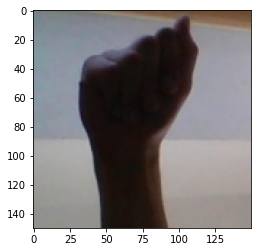

In [ ]:
np_image = sample_training_loader.dataset.__getitem__(0)[0].permute(1, 2, 0).numpy()
imgplot = plt.imshow(np_image)

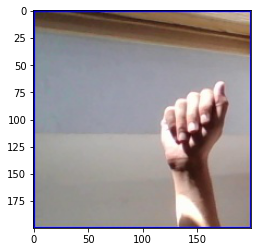

In [ ]:
np_image = sample_test_loader.dataset.__getitem__(0)[0].permute(1, 2, 0).numpy()
imgplot = plt.imshow(np_image)

# New Section

In [ ]:
class Sign_Language_NN(Module):   
    def __init__(self):
        super(Sign_Language_NN, self).__init__()
        #please note that all of the following were arbitrarily chosen: 
        #number of hidden layers, number of nodes per layer, percent dropout, kernel_size, stride, padding

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            
            #input shape: (3,200,200)
            Conv2d(3, 16, kernel_size=4, stride=2, padding='valid'), #output shape: (16,99,99)
            Dropout( p=0.4, inplace=True),
            BatchNorm2d(16),
            ReLU(inplace=True),
            MaxPool2d( kernel_size=3, stride=3),  #output shape: (16,33,33)

            # Defining another 2D convolution layer
            Conv2d( 16, 32, kernel_size=4, stride=1, padding='valid'), #output shape:  (32,30,30)
            Dropout(p=0.4, inplace=True),
            BatchNorm2d(32),
            ReLU(inplace=True ),
            MaxPool2d(kernel_size=2, stride=2),  #output shape: (32,15,15)
            
            # Defining another 2D convolution layer
            Conv2d(32, 16, kernel_size=3, stride=1, padding='valid'), # output shape (16, 13, 13)
            Dropout(p=0.4, inplace=True),
            BatchNorm2d(16),
            ReLU(inplace=True )
            # MaxPool2d(kernel_size=2, stride=2)   
        )

        self.linear_layer = nn.Sequential(
          
            nn.Linear(in_features=fc_input_shape, out_features=number_classes)
            #I don't understand what dim is, but it seems like it's always supposed to be 1
            # nn.Softmax( dim=1) 
            #actually, by using CrossEntropyLoss, we automatically get a softmax activation function
        )        

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        # print('shape0-after_forward: ', x.shape[0])
        # print('shape1-after_forward: ', x.shape[1])
        # print('shape2-after_forward: ', x.shape[2])
        # print('shape3-after_forward: ', x.shape[3])        
        
        #Flatten each image such that x will have shape: (BATCH_SIZE, channels*height*width)
        x = x.view(x.shape[0], -1)  
        x = self.linear_layer(x)
        x=F.softmax(x)
        return x


    
    

In [ ]:
start_time2 = time()


In [ ]:
# defining the model
model = Sign_Language_NN()
# defining the optimizer; lr was copied from another notebook and as such is arbitrary
optimizer = Adam(model.parameters(), lr=0.001)  
# defining the loss function
loss_func = CrossEntropyLoss()       
# checking if GPU is available

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu") #use above line once we want to use gpu
model.to(device)
# print(model.is_cuda)
# print(device)

# get_all_data = validation_data_loader.... #TODO: 
training_loss_by_epoch = []
training_accuracy_by_epoch = []
val_loss_by_epoch = []
val_accuracy_by_epoch = []

EPOCHS=15
for epoch in range(EPOCHS): 
    print('epoch #:', epoch)
    model.train()
    training_loss = 0  
    train_correct = 0     
    for step, (x, y) in enumerate(sample_training_loader):
        # x: (batch of 10 images)
        # y (batch of target classes for the 10 images of x)
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()           
        predicted_y = model(x)     
        loss = loss_func(predicted_y, y)  

        #print('batch training loss:', loss.item())
        training_loss += loss.item()
        # print('loss before backward:', loss)
        loss.backward()    #backpropogation
        # print('loss after backward:', loss)                     
        optimizer.step()   #update weights
        _, predicted = torch.max(predicted_y.data, 1)
        train_correct += (predicted == y).sum().item()

    avg_train_accuracy = 100 * train_correct / (BATCH_SIZE*(step + 1))
    print('Training Accuracy for epoch', epoch, ':', avg_train_accuracy)
    training_accuracy_by_epoch.append(avg_train_accuracy)    


    avg_train_loss = training_loss/(step+1)    
    print('training_loss for epoch ', epoch, ':', avg_train_loss)
    training_loss_by_epoch.append(avg_train_loss)    

    model.eval()
    val_losses = 0
    val_correct = 0
    for step, (x, y) in enumerate(sample_validation_loader):
        x = x.to(device)
        y = y.to(device)

        # print('val x.shape', x.shape)
        # print('val y.shape', y.shape)

        predicted_y = model(x)     
        loss = loss_func(predicted_y, y)  
        val_losses += loss.item()
        _, predicted = torch.max(predicted_y.data, 1)
        val_correct += (predicted == y).sum().item()

    avg_val_accuracy = 100 * val_correct / (BATCH_SIZE*(step + 1))
    print('Validation Accuracy for epoch', epoch, ':', avg_val_accuracy)
    val_accuracy_by_epoch.append(avg_val_accuracy)    


    avg_val_loss = val_losses/(step+1)
    print('validation loss for epoch ', epoch, ':', avg_val_loss)
    val_loss_by_epoch.append(avg_val_loss)

#Top priority todos:
#TODO: Literature Review




#-----
#TODO: Use transfer learning for one of three purposes: 
#a) Comparing model performance
#b) Use model (with transfer learning) that identifies lots of different objects for understanding useful information about edges, 
# non-linear lines, and other aspects of image processing in general
#c) Use model (with transfer learning) that was used on hand gestures to gain more specific information 
# on aspects of hand gestures that could very easily transfer to the learning of American Sign Language characters (which are hand gestures)
#TODO: Small strides at the beginning 1-2 layers in order to detect things like creases
#TODO: Visualize learning curves: (At end of the notebook): -->
        # https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/main/projects/ComputerVision/spectrogram_analysis.ipynb#scrollTo=lfgYvTkEvVf9
#Useful information:
#Inccreased filters --> increases how much you learn about each location and increases expressivity of a model.
     #Increase the number of filters as we go deeper into network and then decrease the filters
#kernel size --> [3,4,5] --> depends on the size of the features we want to capture
# Decrease number filters as you go on because --> each filter now captures more complex features as we go deeper into the network
# Input size large enough to preserve information for the task
     # --> (Bigger images --> longer training)
     # --> (Smaller images --> lesser training time)
     # scikit image for resizing, or use transformer in pytorch (we saw a transformer for this in previous notebook)
# Consider increasing number of layers (decrease image size to speed things up if you add layers)
# Consider cropping just the middle to get image with lower dimensions but make sure no hand gesture is cropped
# Create a softmax

#DONE:
#TODO: As per model colab notebook: We need to have a question, hypothesis, and data  (DONE)
#TODO: Validation and tracking validation loss  (DONE) 
#TODO: Create a larger training dataset  (DONE)
#TODO: Create a test dataset and upload it via a new dataloader (the same way we do our training data)  (DONE)   
#TODO: should this optimizer be in the class above?  No  (DONE)
#TODO: should this loss function be in the class above?  No  (DONE)
#TODO: check how we use .cuda() -- what do we use it on and do we use assignment to do so 
#         i.e. just "model.cuda()" vs. "model = model.cuda()"?  (DONE)   
#TODO: Create visualizations for training & validation accuracy & loss (assigned to Sakayo)
#TODO: Change stride, kernel size (assigned to Ari)
#TODO: Check that loss function works properly (it hasn't been recently, but this might be fixed by SoftMax)

#TODO from Alex:
#Change learning rate

#To ask Alex:
# TODO: How do we decide which hyperparameters to use? How many:
# layers, how many filters, stride, kernel size
# TODO: Manipulating input image: resize, data augmentation
# TODO: MaxPooling vs. Average Pooling? 
# TODO: 

epoch #: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


RuntimeError: ignored

In [ ]:
end_time2 = time()
time_train_validate = end_time2 - start_time2
print("Time to get through training and validation:", time_train_validate)

Time to get through training and validation: 2026.2113482952118


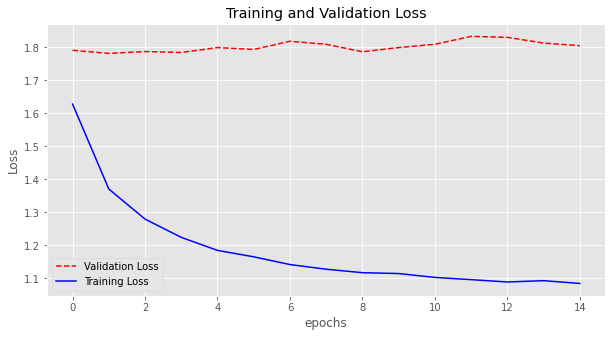

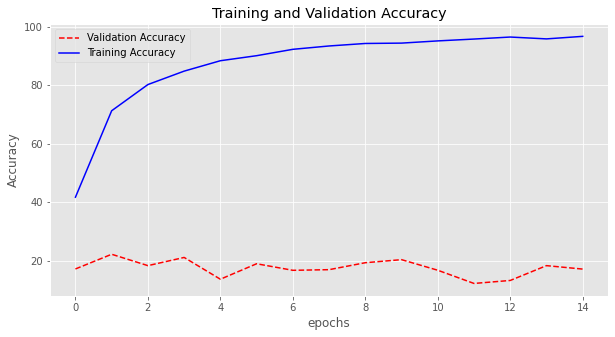

In [ ]:
%matplotlib inline
plt.style.use('ggplot')

#Plot Validation and traning loss
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_loss_by_epoch, '--',label="Validation Loss", color = 'red')
plt.plot(training_loss_by_epoch,label="Training Loss",color='blue')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#Plot Validation and traning Accuracy

plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accuracy_by_epoch, '--',color='red',label="Validation Accuracy")
plt.plot(training_accuracy_by_epoch,color='blue',label="Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
end_time3 = time()
time_plot = end_time3 - start_time2
print("Time to get through plotting:", time_plot)

Time to get through plotting: 3707.8220896720886
